# Sparse Kernel

## Support Vector Machine

Reference
- https://www.youtube.com/watch?v=QSEPStBgwRQ
- pattern recognition and machine learning, chapter 7

Difference between SVM and Logistic Regression
- major difference is that SVM uses hinge loss while logistic regression uses cross-entropy loss.

### SVM Problem

0. Data

    x: input, $x \in \mathbb{R}^D$

    t: target, $t \in \{-1, 1\}$

1. Model

$$f(x) = w^T x + b$$

$$
g(x) = \begin{cases}
1 & \text{if } f(x) \geq 0 \\
-1 & \text{otherwise}
\end{cases}
$$

2. Loss Function

The ideal loss function is 0-1 loss function, where the loss is 0 if $g(x) = t$ and 1 otherwise. 
This loss function counts the number of times the model gets incorrect results on the training data.
However, this is not convex and not differentiable. 

$$ 
L(x, t) = \sum_{n=1}^N \delta (g(x_n) \neq t_n)
$$



### Hinge Loss and Cross-Entropy Loss

**ideal loss** function: 0-1 loss
    $$
    l = \begin{cases}
    0 & \text{if } t_nf(x_n) \geq 0 \\
    1 & \text{otherwise}
    \end{cases}
    $$

Because this loss function is not convex and not differentiable, we need to use other loss functions $l$, so that,
$$
L(x, t) = \sum_{n=1}^N l(t_n, f(x_n))
$$

The form of $l$ could be different, such as square error, cross-entropy, hinge loss, etc.
However, different loss function might lead to different performance. 

**square loss**

for square loss, we want to minimize the square error between the prediction and the target.
$$
l = (t_nf(x_n) - 1)^2
$$

This is not good for classification, because we want that `when the prediction is correct, the loss should be small`.
- for square loss, when the prediction is correct, $t_nf(x_n)$ could be a large positive number, which leads to a large loss.

**sigmoid + square loss**

we want:
- when $t_n = 1$, $\sigma (f(x_n))$ close to 1 $\rightarrow$ $(\sigma (f(x_n)) - 1)^2$
- when $t_n = -1$, $\sigma (f(x_n))$ close to 0 $\rightarrow$ $(\sigma (-f(x_n)) - 1)^2 = (1- \sigma(f(x)) - 1)^2 = (\sigma (f(x)))^2$
  
Then we can write the loss function as:
$$
l = ( \sigma (t_nf(x_n)) - 1)^2
$$

However, this is still not good for classification, because this changes over sigmoid function is very small, which would lead to slow learning.
- when $t_n f(x_n)$ is very negative (very wrong prediction), the change of the loss function is very small, which would lead to slow learning.

**sigmoid + cross-entropy loss (logistic regression)**

we want:
- when $t_n = 1$, $\sigma (f(x_n))$: probability of $t_n = 1$ 
- when $t_n = -1$, $1 - \sigma (f(x_n))$

then we can write the loss function as: -> this will need some derivation
$$
l = \ln (1 + e^{(-t_nf(x_n))})
$$

This function is a good loss function for classification, because:
- when $t_nf(x_n)$ is very negative, the loss function is very large, and the slope is steep, which would lead to large changes in the model.
- when $t_nf(x_n)$ is very positive, the loss function is very small, and the slope is almost flat, which would lead to small changes in the model.

**hinge loss**

Although the cross-entropy loss is a good loss function for classification, but for SVM, we want   
- when $t_nf(x_n)$ is positive and greater than some threshold, e.g., 1, the loss should be 0, because we dont care about the prediction that is very correct.
- when $t_nf(x_n)$ is negative, we want to quicky decrease the loss to make it positive (correct prediction)
  
  $$
  l = \max(0, 1 - t_nf(x_n))
  $$

Why the threshold is 1?
- 1 can make sure hinge loss is a tight upper bound for 0-1 loss. This can be visualized in the loss plot.

Also a good loss function for classification, because:
  - if the prediction is correct, the loss is 0
  - more robust to outliers than cross-entropy loss
    - if the prediction is very wrong, the cross-entropy loss is greater than the hinge loss. Thus for outliers, cross-entropy loss might be more sensitive by adjusting parameters more.


### Linera SVM Formulation

\begin{align}
\min_{w, b} \quad & \sum_{n}^{N} \max(0, 1 - t^n f(x_n)) + \lambda w^2 \\
\end{align}




### General SVM Formulation

use $\epsilon_n$ to replace the hingle loss at $x_n$: $\max(0, 1- t_nf(x_n))$

we have:
$$
\epsilon_n = \max(0, 1- t_nf(x_n))
$$

therefore,

$$
t_n f(x_n) \ge 1 - \epsilon_n
$$

The overall formulation is then:

\begin{align}
\min_{w, b, \epsilon} \quad & \frac{1}{2} w^T w + C \sum_{n=1}^N \epsilon_n \\
\text{subject to} \quad & t_n f(x_n) \ge 1 - \epsilon_n \\
& \epsilon_n \ge 0
\end{align}

where $C$ is a hyperparameter that controls the trade-off between the slack variable penalty and the margin.

This leads to a quadratic programming problem, which can be solved by QP solver.


### Optimization

Gradient Descent

### Kernel Trick


In [87]:
import jax
import jax.numpy as jnp
from sklearn import datasets
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)   

from basic.kernel.kernel import Linear
from basic.kernel.kernel import RadialBasisFunction
from basic.sparse_kernel.svm import BinarySVC


(50,)


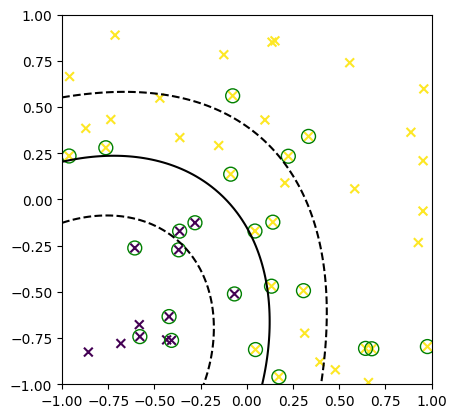

In [88]:
def create_toy_data():
    x = np.random.uniform(-1, 1, 100).reshape(-1, 2)
    y = x < 0
    y = (y[:, 0] * y[:, 1]).astype(np.float32)
    return x, np.sign(1 - 2 * y)

# Prepare data.
X, y = create_toy_data()
#X = preprocessing.Normalizer().fit_transform(X)
#y = jnp.array(y * 2. - 1)  # Transform labels from {0, 1} to {-1., 1.}.

C = 2

# Compare the obtained dual coefficients.
# kernels 
linear_kernel = Linear()
rbf_kernel = RadialBasisFunction()
rbf_kernel_params = {'variance': 1.0, 'length_scale': 1.0}

# svc
svc = BinarySVC(kernel=rbf_kernel, kernel_params=rbf_kernel_params, C=C)
beta, sv_index = svc.fit(X, y)
sv_x = X[sv_index]
sv_y = y[sv_index]

# predict
#svc_predict = jax.jit(svc.predict)
svc_predict = svc.predict
y_predict = svc_predict(X_test=X, 
                        X_train=X, 
                        y_train=y, 
                        beta=beta, 
                        sv_index=sv_index)
print(y_predict.shape)
x0, x1 = jnp.meshgrid(jnp.linspace(-1, 1, 100), jnp.linspace(-1, 1, 100))
x = jnp.array([x0, x1]).reshape(2, -1).T

plt.scatter(X[:, 0], X[:, 1], s=40, c=y, marker="x")
plt.scatter(sv_x[:, 0], sv_x[:, 1], s=100, facecolor="none", edgecolor="g")
plt.contour(
    x0, x1, svc.distance(x, X, y, beta, sv_index).reshape(100, 100),
    jnp.arange(-1, 2), colors="k", linestyles=("dashed", "solid", "dashed"))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect("equal", adjustable="box")


In [89]:
y

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,
        1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,
       -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.],
      dtype=float32)